# Modeling & Classification.




~~usar varios clusters, uno de 3grams, uno de nouns, uno de embeddings~~   
~~con esto buscar un clasificador multilabel (o simplemente agregarlos como features del modelo que le fedee al clasificador)~~  

Des métodos para clusterizar:    
-primero hago cluster separados para Tags, 2-3grams, Keys    
    luego agrego estas nuevas features al embedding, con eso puedo entrenar el clasificador.          
  
-segundo usando topic modeling q todavia no investigue     


Orden:  
Crear Espacio,  
normalizarlo,  
reducirlo,  
hacerle kmeans,  
obtener los clusters,  
medir siluete, gap, inertia, y precision con mi database.  
Agregar la medicion al df de mediciones.  


## Setup

In [1]:
import pandas as pd
import numpy as np
#import fasttext
from patterns import emoji_pattern
from gensim.models import Word2Vec, KeyedVectors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sentence_transformers import SentenceTransformer, util


df = pd.read_csv("db/features.csv", index_col=0)

df


,id,Q,Qless,Qlemmas,Qpos,Qkeys,Qclean,ANS,Aless,Alemmas,Apos,Akeys,Aclean,QA-keys,QA-lemmas
0,ojjgvy,"people that eat spicy food, why?",people eat spicy food,"['people', 'eat', 'spicy', 'food']","[('people', 'NNS'), ('eat', 'VBP'), ('spicy', ...",people_NNS eat_VBP spicy_NN food_NN,people that eat spicy food why,"I never liked spicy food, it just adds a pain ...",I never liked spicy food adds pain element don...,"['I', 'never', 'liked', 'spicy', 'food', 'add'...","[('I', 'PRP'), ('never', 'RB'), ('liked', 'VBD...",I_PRP never_RB liked_VBD spicy_NN food_NN add_...,I never liked spicy food it just adds a pain e...,people_NNS eat_VBP spicy_NN food_NN I_PRP nev...,"['people', 'eat', 'spicy', 'food', 'I', 'never..."
1,bc60pk,"donut or doughnut, & where are you from?",donut doughnut,"['donut', 'doughnut']","[('donut', 'NN'), ('doughnut', 'NN')]",donut_NN doughnut_NN,donut or doughnut where are you from,"donut, southern usa",donut southern usa,"['donut', 'southern', 'usa']","[('donut', 'NN'), ('southern', 'JJ'), ('usa', ...",donut_NN usa_NN,donut southern usa,donut_NN doughnut_NN donut_NN usa_NN,"['donut', 'doughnut', 'donut', 'southern', 'usa']"
2,289mmm,help finding a song from a video description?,help finding song video description,"['help', 'finding', 'song', 'video', 'descript...","[('help', 'NN'), ('finding', 'NN'), ('song', '...",help_NN finding_NN song_NN video_NN descriptio...,help finding a song from a video description,/r/tipofmytongue,rtipofmytongue,['rtipofmytongue'],"[('rtipofmytongue', 'NN')]",rtipofmytongue_NN,rtipofmytongue,help_NN finding_NN song_NN video_NN descriptio...,"['help', 'finding', 'song', 'video', 'descript..."
3,rufpr/,"i was rapedno, we had sex",rapedno sex,"['rapedno', 'sex']","[('rapedno', 'NN'), ('sex', 'NN')]",rapedno_NN sex_NN,i was rapedno we had sex,"if its not a yes, its no.",yes,['yes'],"[('yes', 'NNS')]",yes_NNS,if its not a yes its no,rapedno_NN sex_NN yes_NNS,"['rapedno', 'sex', 'yes']"
4,24vtw3,jesus h. christ what's his middle name?,jesus h christ whats middle name,"['jesus', 'h', 'christ', 'whats', 'middle', 'n...","[('jesus', 'NN'), ('h', 'NN'), ('christ', 'NN'...",jesus_NN h_NN christ_NN whats_NNS middle_VBP n...,jesus h christ whats his middle name,umm... Holy. As in Holy Christ. Isn't this com...,umm Holy As Holy Christ Isnt common knowledge,"['umm', 'Holy', 'As', 'Holy', 'Christ', 'Isnt'...","[('umm', 'JJ'), ('Holy', 'NNP'), ('As', 'IN'),...",Holy_NNP As_IN Holy_NNP Christ_NNP Isnt_NNP kn...,umm Holy As in Holy Christ Isnt this common kn...,jesus_NN h_NN christ_NN whats_NNS middle_VBP n...,"['jesus', 'h', 'christ', 'whats', 'middle', 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90149,oqcloa,¿what easy work is really difficult?,¿easy work really difficult,"['¿easy', 'work', 'really', 'difficult']","[('¿easy', 'JJ'), ('work', 'NN'), ('really', '...",work_NN really_RB,¿what easy work is really difficult,None by virtue of it being easy in the first p...,None virtue easy first place,"['None', 'virtue', 'easy', 'first', 'place']","[('None', 'NN'), ('virtue', 'NN'), ('easy', 'V...",None_NN virtue_NN easy_VBP place_NN,None by virtue of it being easy in the first p...,work_NN really_RB None_NN virtue_NN easy_VBP ...,"['¿easy', 'work', 'really', 'difficult', 'None..."
90150,ooswef,daddy what does nsfw mean?,daddy nsfw mean,"['daddy', 'nsfw', 'mean']","[('daddy', 'JJ'), ('nsfw', 'NNS'), ('mean', 'V...",nsfw_NNS mean_VBP,daddy what does nsfw mean,not safe for work,safe work,"['safe', 'work']","[('safe', 'JJ'), ('work', 'NN')]",work_NN,not safe for work,nsfw_NNS mean_VBP work_NN,"['daddy', 'nsfw', 'mean', 'safe', 'work']"
90151,orgpc4,"quiet people, what are your strengths?",quiet people strengths,"['quiet', 'people', 'strength']","[('quiet', 'JJ'), ('people', 'NNS'), ('strengt...",people_NNS strength_NN,quiet people what are your strengths,"Observing, attention, memory,",Observing attention memory,"['Observing', 'attention', 'memory']","[('Observing', 'VBG'), ('attent

## Modeling

In [2]:
Models = {}

### Tfidf Models

In [3]:
def tdidf_model(df, column, range=(2,3), min_df=20, threshold=1e-3, ngram=False):
    
    docs = df[column].fillna("")

    if ngram:
        tdidf = TfidfVectorizer(min_df=min_df, ngram_range=range)
    else:
        tdidf = TfidfVectorizer(min_df=min_df)

    #Create, Normalize and Reduce 
    model = tdidf.fit_transform(docs)
    model = normalize(model, axis=1, norm="max")
    model = VarianceThreshold(threshold=threshold).fit_transform(model)

    return model

In [4]:
#Qkeys is a previously prunned pair of lemmas_PoS
Models["Q-keys"] = tdidf_model(df, column="Qkeys", min_df=15)

#Qless is with stopwords removed
Models["Q-ngrams"] = tdidf_model(df, column="Qless", range=(2,3), min_df=15, ngram = True)

#Question+Answer lemma_keys
Models["QA-keys"] = tdidf_model(df, column="QA-keys", min_df=15)

### Embeddings

https://kavita-ganesan.com/fasttext-vs-word2vec/

In [8]:

def w2v_doc_embedding(docs_toks):

    docs_model = []
    
    words_model = Word2Vec(docs_toks, size=300, workers=8, seed=0)

    for tokens in docs_toks:
        zero_vector = np.zeros(words_model.vector_size)
        vectors = []
        for token in tokens:
            if token in words_model.wv:
                try:
                    vectors.append(words_model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            docs_model.append(avg_vec)
        else:
            docs_model.append(zero_vector)
    return docs_model

Models["w2v-Q"] = w2v_doc_embedding(list(df["Qlemmas"]))
Models["w2v-QA"] = w2v_doc_embedding(list(df["QA-lemmas"]))


### Pretrained Embeddings

- SBERT , glove-6B-300
    * Q, QLess, QA, QAless  


In [ ]:
glove60 = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False, no_header=True)
def glove_doc_embedding(docs_toks, words_model):

    docs_model = []
    

    for tokens in docs_toks:
        zero_vector = np.zeros(words_model.vector_size)
        vectors = []
        for token in tokens:
            try:
                vectors.append(words_model[token])
            except KeyError:
                continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            docs_model.append(avg_vec)
        else:
            docs_model.append(zero_vector)
    return docs_model
    
Models["glove-Q"] = glove_doc_embedding(list(df["Qtoks"]), glove60)


In [3]:
model = SentenceTransformer('nreimers/MiniLM-L6-H384-uncased') #
Models["SBERT"] = model.encode(list(df["Q"].astype('str')), batch_size=70, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)


Downloading: 100%|██████████| 614/614 [00:00<00:00, 210kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [01:16<00:00, 1.19MB/s]
Downloading: 100%|██████████| 316/316 [00:00<00:00, 91.2kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 275kB/s]


### Topic Modeling
https://github.com/ddangelov/Top2Vec
https://pythonrepo.com/repo/ddangelov-Top2Vec-python-natural-language-processing

In [4]:
from top2vec import Top2Vec

Models["top2vec"] = Top2Vec(list(df["Q"].astype('str')), embedding_model='universal-sentence-encoder')


2021-11-30 23:26:54,820 - top2vec - INFO - Pre-processing documents for training
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2021-11-30 23:26:58,355 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 20.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 40.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 60.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 80.00MB
INFO:absl:Downloading https://tfhub.dev/google/univers

## Clustering



Solo voy a probar con KMeans por cuestion de cantidad de datos y recursos, lo que me permite

https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92
https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html


### Evaluation

inertia, silhuete, own_metric

/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mauro/.local/lib

7

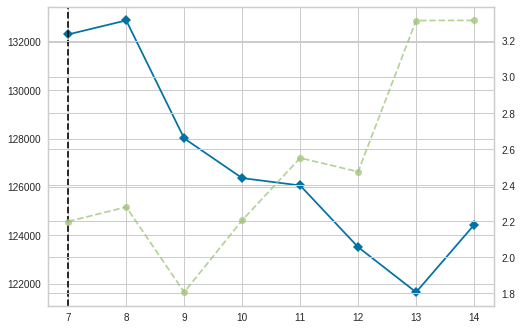

In [ ]:
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
from yellowbrick.cluster import KElbowVisualizer

#https://scikit-learn.org/stable/modules/clustering.html
model = KMeans()
visualizer = KElbowVisualizer(model, k=(7,15))

visualizer.fit(vs)

n_clusters =  visualizer.elbow_value_

#visualizer.show()    
n_clusters

In [ ]:
from sklearn.cluster import KMeans, 

kmc = KMeans(n_clusters=n_clusters,  random_state=0)
kmc.fit(X=vs)

df["label1"] = kmc.labels_

#vemos los primeros clusters, al ser con ngrams  la forma en la que comienza la pregunta tiene mucho peso
def print_kmc_clus(n=10):
    import random
    q_clus = [[] for i in range(n_clusters)]

    for sentence_id, cluster_id in enumerate(kmc.labels_):
        q_clus[cluster_id].append(df.iloc[sentence_id].Q)

    for i, cluster in enumerate(q_clus):
        print(f"Cluster {i+1}, len: {len(cluster)}" )
        for tw in random.sample(cluster, n):
            print(tw)
        print("\n")
print_kmc_clus()


Cluster 1, len: 2652
People with allergies: why?
Homophobes why do not like gay people?
What are things people take WAY to seriously?
People who do NOT pee on the shower, why?
People who hate pineapple on pizza why ?
People who bleach their teeth, why?
To the people that don’t prefer ass: why not?
People who cut all contact to their family , why?
People who ate glue, what did it taste like?
Deaf people, what do you think of song lyrics?


Cluster 2, len: 28760
Where to buy Arkham Knight Red Hood jacket?
The customer is always right? Fuck you
Who do you think is the wisest person alive ?
Funny things to do when home alone?
What's the next hyped video game?
Do miracles happen? If yes, what's your story?
how did the pandemic change your personality?
Which tv/movie best describes your life and why?
Who is the most biased form of media on tv?
Who is your favorite European?


Cluster 3, len: 2271
What’s your favorite Jackass stunt of all time?
What’s the best name you’ve heard for a cat/ dog

In [ ]:
df["label1"] = kmc.labels_
#Compara la cantidad de aciertos con los df de test
def check_results():
    test_df = pd.read_csv("db/test_db.csv", index_col=0)
    true_df = test_df[test_df["2"]]
    false_df = test_df[test_df["2"] == False]

    n = len(true_df)
    m = len(false_df)
    same_c = 0
    for i in range(n):
        if int(df.loc[true_df.iloc[i][0]].label1) ==  int(df.loc[true_df.iloc[i][1]].label1):
            same_c += 1
    
    diff_c = 0
    for i in range(m):
        if int(df.loc[false_df.iloc[i][0]].label1) !=  int(df.loc[false_df.iloc[i][1]].label1):
            diff_c += 1
        
    return same_c/n, diff_c/m
        
check_results()
    

(0.35882828282828283, 0.7212772127721278)

In [ ]:
#continuo viendo que funciona

#embeddings preentrenados
# import gensim.downloader

# #word2vec-google-news-300
# w2v = gensim.downloader.load('glove-twitter-25')
# w2v["mauro"]

df

,Qscore,Q,Qless,Qlemmas,Qkeys,Qtags,ANSscore,ANS,Aless,Alemmas,Akeys,label1
id,,,,,,,,,,,,
bc60pk,14,"Donut or doughnut, & where are you from?","Donut doughnut, & ?","Donut doughnut , & ?",Donut_NNP doughnut_NN,NaN,6.0,"donut, southern usa","donut, southern usa","donut , southern usa",donut_NN usa_NN,3
289mmm,2,Help finding a song from a video description?,Help finding song video description?,Help finding song video description ?,Help_NNP finding_NN song_NN video_NN descripti...,NaN,2.0,/r/tipofmytongue,/r/tipofmytongue,/r/tipofmytongue,/r/tipofmytongue_NN,6
rufpr/,898,"I was rapedNo, we had sex","I rapedNo, sex","I rapedNo , sex",rapedNo_VBP sex_NN,I_PRP rapedNo_VBP,1286.0,"if its not a yes, its no.","yes, .","yes , .",yes_RB,3
24vtw3,22,Jesus H. Christ what's his middle name?,Jesus H. Christ 'middle name?,Jesus H. Christ 'middle name ?,Jesus_NNP H._NNP Christ_NNP name_NN,NaN,35.0,umm... Holy. As in Holy Christ. Isn't this com...,umm... Holy. As Holy Christ. Isn'common knowle...,umm ... Holy . As Holy Christ . Isn'common kno...,umm_NN Holy_NNP Holy_NNP Christ_NNP Isn'common...,3
sv054/,0,Judith from hotmail sent me a message..... ),Judith hotmail sent message..... ),Judith hotmail sent message ..... ),Judith_NNP hotmail_NN sent_VBD message_NN .......,sent_VBD,3.0,sounds like a great idea!,sounds like great idea!,sound like great idea !,sound_NN idea_NN,3
...,...,...,...,...,...,...,...,...,...,...,...,...
orgpc4,1,"Quiet people, what are your strengths?","Quiet people, strengths?","Quiet people , strength ?",people_NNS strength_NN,NaN,4.0,"Observing, attention, memory,","Observing, attention, memory,","Observing , attention , memory ,",Observing_NN attention_NN memory_NN,0
og7m7k,1,What is the best indian movie?,What best indian movie?,What best indian movie ?,movie_NN,What_WP,2.0,Why is this a quote?,Why quote?,Why quote ?,quote_NN,9
olnost,1,"Who's the best MC's, Biggie, Jay-Z, and Nas?","Who'best MC', Biggie, Jay-Z, Nas?","Who'best MC ' , Biggie , Jay-Z , Nas ?",Who'best_NNP MC_NNP Biggie_NNP Jay-Z_NNP Nas_NNP,NaN,1.0,whyd you put your question in quotes?,whyd put question quotes?,whyd put question quote ?,whyd_NN put_VBD question_NN quote_NN,3


In [ ]:
kmc.labels_

array([3, 6, 3, ..., 3, 3, 0], dtype=int32)

## Classifying 
